In [1]:
# !pip install SimpleITK
# !pip install scikit-image
# !pip install scikit-image

In [2]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
import os

reference_image = nib.load('../images/FLAIR.nii.gz').get_fdata()
switch_image = nib.load('../images/T1.nii.gz').get_fdata()
switch_seg_image = nib.load('../images/seg7.nii.gz').get_fdata()
imagen_movil = nib.load('../images/T1.nii.gz')
imagen_estatica = nib.load('../images/FLAIR.nii.gz')

Fixed image :  (240, 240, 48)
Moving image :  (256, 256, 192)
Segmentated image :  (256, 256, 192)


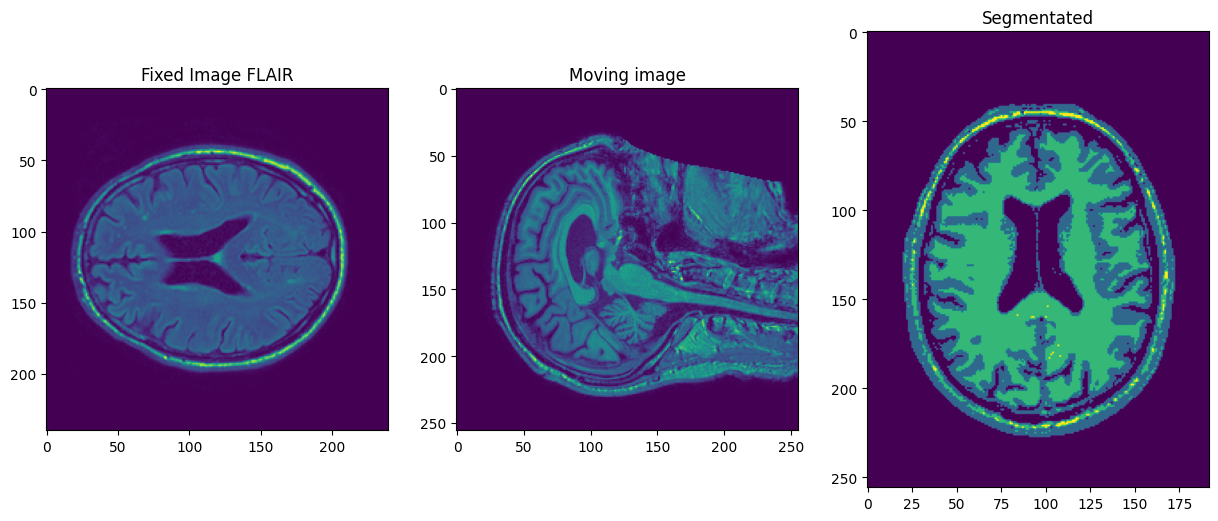

In [3]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 8))
ax1.imshow(reference_image[:, :, 25])
ax1.set_title('Fixed Image FLAIR')
ax2.imshow(switch_image[:, :, 100])
ax2.set_title('Moving image')
ax3.imshow(switch_seg_image[:, 91, :])
ax3.set_title('Segmentated')

print("Fixed image : ", reference_image.shape)
print("Moving image : ", switch_image.shape)
print("Segmentated image : ", switch_seg_image.shape)

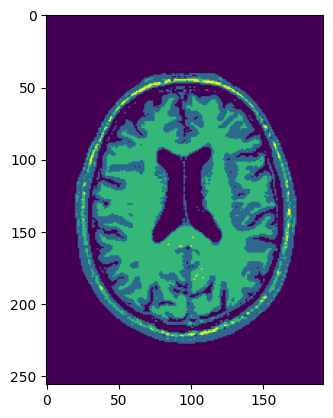

In [4]:
plt.imshow(switch_seg_image[:, 91, :])

In [5]:
def registro_rigido(imagen_movil, imagen_referencia, imagen_seg, output_folder="../images/"):
    # Cargar las imágenes usando SimpleITK
    imagen_movil_sitk = sitk.ReadImage(imagen_movil)
    imagen_referencia_sitk = sitk.ReadImage(imagen_referencia)
    imagen_seg_sitk = sitk.ReadImage(imagen_seg)

    # Convertir la imagen móvil a tipo de datos float32
    imagen_movil_sitk = sitk.Cast(imagen_movil_sitk, sitk.sitkFloat32)
    imagen_seg_sitk = sitk.Cast(imagen_seg_sitk, sitk.sitkFloat32)

    # Crear el objeto de registro rígido
    registro_rigido = sitk.ImageRegistrationMethod()

    # Configurar los parámetros del registro rígido
    registro_rigido.SetMetricAsMeanSquares()
    registro_rigido.SetOptimizerAsRegularStepGradientDescent(learningRate=0.1, minStep=1e-4, numberOfIterations=100)
    registro_rigido.SetInitialTransform(sitk.TranslationTransform(imagen_movil_sitk.GetDimension()))

    # Realizar el registro rígido
    transformada_resultado = registro_rigido.Execute(imagen_referencia_sitk, imagen_movil_sitk)

    # Aplicar la transformación alineada a la imagen móvil completa
    imagen_movil_registrada = sitk.Resample(imagen_seg_sitk, imagen_referencia_sitk, transformada_resultado, sitk.sitkNearestNeighbor, 0.0, sitk.sitkFloat64)

    # Obtener la matriz tridimensional de la imagen móvil registrada y reordenar las dimensiones
    matriz_registrada = sitk.GetArrayFromImage(imagen_movil_registrada)
    matriz_registrada = np.transpose(matriz_registrada, (2, 1, 0))

    # Guardar la imagen registrada en formato NIfTI
    output_path = os.path.join(output_folder, "registration.nii.gz")
    image_segmented = nib.Nifti1Image(matriz_registrada, affine=np.eye(4))
    nib.save(image_segmented, output_path)
    print(f"Imagen segmentada guardada en {output_path}")

    return matriz_registrada


In [6]:
image_registro_rigido = registro_rigido(imagen_movil='../images/IR.nii.gz', imagen_referencia='../images/FLAIR.nii.gz', imagen_seg='../images/IR_seg.nii.gz')

Imagen segmentada guardada en ../images/registration.nii.gz


Text(0.5, 1.0, 'Registered')

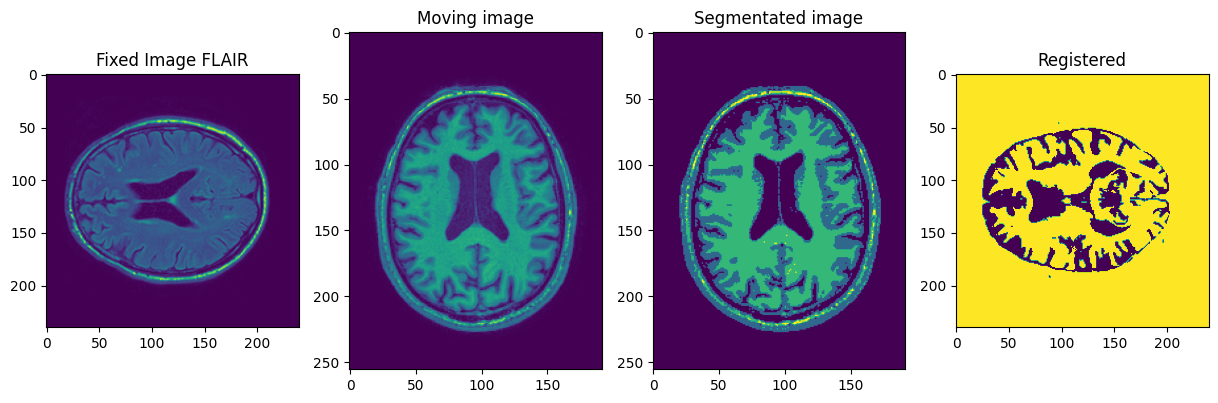

In [7]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 8))
ax1.imshow(reference_image[:, :, 25])
ax1.set_title('Fixed Image FLAIR')
ax2.imshow(switch_image[:, 91, :])
ax2.set_title('Moving image')
ax3.imshow(switch_seg_image[:, 91, :])
ax3.set_title('Segmentated image')
ax4.imshow(image_registro_rigido[:, :, 25])
ax4.set_title('Registered')


In [8]:
print("Fixed image : ", reference_image.shape)
print("Moving image : ", switch_image.shape)
print("Registered image : ", image_registro_rigido.shape)


Fixed image :  (240, 240, 48)
Moving image :  (256, 256, 192)
Registered image :  (240, 240, 48)


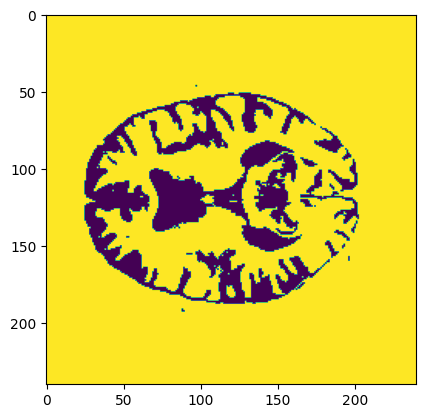

In [9]:
plt.imshow(image_registro_rigido[:, :, 25])